In [2]:
import pandas as pd
import simfin as sf
from simfin.names import *
import numpy as np

#### Import financial data from SimFin API

In [3]:
sf.set_data_dir('~/simfin_data/')
sf.set_api_key(api_key='free')
df_income = sf.load_income(variant='annual', market='us')
df_balance = sf.load_balance(variant='annual', market='us')
df_cashflow = sf.load_cashflow(variant='annual', market='us')
df_companies = sf.load_companies(index=TICKER, market='us')
df_industries = sf.load_industries()

Dataset "us-income-annual" on disk (61 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (61 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (61 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-companies" on disk (61 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "industries" on disk (61 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!


In [3]:
df_income_reduced = df_income[['SimFinId', 'Currency', 'Fiscal Year','Income (Loss) from Continuing Operations',
                               'Revenue','Cost of Revenue', 'Gross Profit','Selling, General & Administrative',
                               'Depreciation & Amortization', 'Non-Operating Income (Loss)']]

df_balance_reduced = df_balance[['SimFinId', 'Currency', 'Fiscal Year','Total Assets','Total Equity',
                                 'Short Term Debt','Long Term Debt', 'Cash, Cash Equivalents & Short Term Investments',
                                 'Long Term Investments & Receivables','Accounts & Notes Receivable','Payables & Accruals',
                                 'Inventories','Property, Plant & Equipment, Net']]

df_cashflow_reduced = df_cashflow[['SimFinId', 'Currency', 'Fiscal Year','Net Cash from Operating Activities',
                                   'Net Cash from Investing Activities', 'Net Cash from Financing Activities']]

#### Extracting the sign of each cashflow item to calculate lifecycle (Dickinson, 2010)

In [4]:
pd.set_option('mode.chained_assignment', None)
df_cashflow_reduced['Op_sign'] = ["+" if company >= 0 else "-" for company in df_cashflow_reduced['Net Cash from Operating Activities']]
df_cashflow_reduced['Inv_sign'] = ["+" if company >= 0 else "-" for company in df_cashflow_reduced['Net Cash from Investing Activities']]
df_cashflow_reduced['Fin_sign'] = ["+" if company >= 0 else "-" for company in df_cashflow_reduced['Net Cash from Financing Activities']]

In [5]:
df_cashflow_reduced['lifecycle'] = None
for row in range(0,len(df_cashflow_reduced)):
    if (df_cashflow_reduced['Op_sign'][row] == '-') & (df_cashflow_reduced['Inv_sign'][row] == '-') & (df_cashflow_reduced['Fin_sign'][row]=="+"):
        df_cashflow_reduced['lifecycle'][row] = 'Introduction'
    elif (df_cashflow_reduced['Op_sign'][row] == '+') & (df_cashflow_reduced['Inv_sign'][row] == '-') & (df_cashflow_reduced['Fin_sign'][row]=="+"):
        df_cashflow_reduced['lifecycle'][row] = 'Growth'
    elif (df_cashflow_reduced['Op_sign'][row] == '+') & (df_cashflow_reduced['Inv_sign'][row] == '-') & (df_cashflow_reduced['Fin_sign'][row]=="-"):
        df_cashflow_reduced['lifecycle'][row] = 'Mature'
    elif (df_cashflow_reduced['Op_sign'][row] == '-') & (df_cashflow_reduced['Inv_sign'][row] == '-') & (df_cashflow_reduced['Fin_sign'][row]=="-"):
        df_cashflow_reduced['lifecycle'][row] = 'Shake-out'
    elif (df_cashflow_reduced['Op_sign'][row] == '+') & (df_cashflow_reduced['Inv_sign'][row] == '+') & (df_cashflow_reduced['Fin_sign'][row]=="+"):
        df_cashflow_reduced['lifecycle'][row] = 'Shake-out'
    elif (df_cashflow_reduced['Op_sign'][row] == '+') & (df_cashflow_reduced['Inv_sign'][row] == '+') & (df_cashflow_reduced['Fin_sign'][row]=="-"):
        df_cashflow_reduced['lifecycle'][row] = 'Shake-out'
    else:
        df_cashflow_reduced['lifecycle'][row] = 'Decline'

In [6]:
df_cashflow_reduced.groupby(['lifecycle'])['lifecycle'].count()

lifecycle
Decline          773
Growth          4240
Introduction    1681
Mature          8404
Shake-out       1395
Name: lifecycle, dtype: int64

In [7]:
df_cashflow_lifecycle = df_cashflow_reduced.drop(['Net Cash from Operating Activities','Net Cash from Investing Activities',
                                            'Net Cash from Financing Activities', 'Op_sign', 'Inv_sign', 'Fin_sign'], axis=1)

In [8]:
df_financial = df_income_reduced.merge(df_balance_reduced, on=['Report Date', 'SimFinId', 'Currency', 'Fiscal Year']).merge(df_cashflow_lifecycle, on=['Report Date', 'SimFinId', 'Currency', 'Fiscal Year'])
df_financial.reset_index(level=0, inplace=True)

#### Ckecking null values on financial data set

In [9]:
print(df_financial.isnull().sum()/len(df_financial))

Report Date                                        0.000000
SimFinId                                           0.000000
Currency                                           0.000000
Fiscal Year                                        0.000000
Income (Loss) from Continuing Operations           0.000000
Revenue                                            0.015886
Cost of Revenue                                    0.093919
Gross Profit                                       0.015219
Selling, General & Administrative                  0.049961
Depreciation & Amortization                        0.563027
Non-Operating Income (Loss)                        0.011156
Total Assets                                       0.000000
Total Equity                                       0.000121
Short Term Debt                                    0.337477
Long Term Debt                                     0.219548
Cash, Cash Equivalents & Short Term Investments    0.002971
Long Term Investments & Receivables     

In [10]:
print(len(df_financial))

16493


#### Dropping companies that didn't report revenues or costs. Problably holdings that don't have operation.

In [11]:
drop_row_null = list(df_financial.index[df_financial['Revenue'].isnull() == True]) # 262 rows
df_financial = df_financial.drop(drop_row_null)
drop_row_zero = list(df_financial.index[df_financial['Revenue']==0]) #135 rows
df_financial = df_financial.drop(drop_row_zero)
drop_row_null_cost = list(df_financial.index[df_financial['Cost of Revenue'].isnull() == True]) # 262 rows
df_financial = df_financial.drop(drop_row_null_cost)
drop_row_zero_cost = list(df_financial.index[df_financial['Cost of Revenue']==0]) #32 rows
df_financial = df_financial.drop(drop_row_zero_cost)
len(df_financial)

14872

#### Some companies doesn't report values for some of the lines because they don't have it. So it was replaced by zero

In [12]:
df_financial = df_financial.fillna(0) 

#### Calculating numerical dependent variables

In [13]:
#Some of the items already carries negative values (e.g. Cost of Revenue and Selling, General & Administrative)
#All formulas were adapted
df_financial['total.debt'] = df_financial['Short Term Debt'] + df_financial['Long Term Debt']
df_financial['size'] = np.log(1+df_financial['Total Assets'])
df_financial['leverage'] = df_financial['total.debt']/df_financial['Total Assets']
df_financial['ebit'] = df_financial['Revenue'] + df_financial['Selling, General & Administrative']
df_financial['ebitda'] = df_financial['ebit'] - df_financial['Depreciation & Amortization']
df_financial['roa'] = df_financial['Income (Loss) from Continuing Operations']/df_financial['Total Assets']
df_financial['roe'] = df_financial['Income (Loss) from Continuing Operations']/df_financial['Total Equity']
df_financial['roic'] = df_financial['Income (Loss) from Continuing Operations']/(df_financial['Total Assets'] - df_financial['Cash, Cash Equivalents & Short Term Investments'] - df_financial['Long Term Investments & Receivables'])
df_financial['gross.profit.margin'] = df_financial['Gross Profit']/df_financial['Revenue']
df_financial['ebit.margin'] = df_financial['ebit']/df_financial['Revenue']
df_financial['net.profit.margin'] = df_financial['Income (Loss) from Continuing Operations']/df_financial['Revenue']
df_financial['asset.turnover'] = df_financial['Revenue']/df_financial['Property, Plant & Equipment, Net']
df_financial['financial.leverage'] = df_financial['Income (Loss) from Continuing Operations']*df_financial['Total Assets']/df_financial['Total Equity']/(df_financial['Income (Loss) from Continuing Operations']-df_financial['Non-Operating Income (Loss)'])
df_financial['operational.leverage'] = df_financial['Gross Profit']/(df_financial['Gross Profit']+df_financial['Selling, General & Administrative'])
df_financial['dso'] = (df_financial['Accounts & Notes Receivable']*360)/df_financial['Revenue']
df_financial['dpo'] = (df_financial['Accounts & Notes Receivable']*360)/df_financial['Revenue']
df_financial['dio'] = (df_financial['Inventories']*360)/df_financial['Cost of Revenue']*-1

In [14]:
df_financial = df_financial[['Report Date','SimFinId', 'Currency', 'Fiscal Year', 'Revenue', 'Income (Loss) from Continuing Operations', 
                                   'total.debt', 'size', 'leverage', 'ebit', 'ebitda', 'roa', 'roe', 'roic',
                                   'gross.profit.margin', 'ebit.margin', 'net.profit.margin',
                                   'asset.turnover', 'financial.leverage', 'operational.leverage', 'dso',
                                   'dpo', 'dio', 'lifecycle']]

#### Gathering Industry Segment Information, cik (unique) number, and company name 

In [15]:
# merging tables to gather companies' names
df_financial = df_financial.merge(df_companies, on ='SimFinId', how ='left').drop(['IndustryId'],axis=1)
companies_txt = pd.read_csv(r'C:\Users\alyss\Desktop\MS BAIS\Fall 2020\ISM6930 - Text Analytics\Team Project\Financial Statements NLP\Final Project\companies_sec.csv')
companies_txt = companies_txt.drop('Unnamed: 0', axis=1)

In [16]:
# In the SEC dataset, sic numbers has 4 digits. We are spliting companies by the first 2 digits to reduce the number of industries.
import math
companies_txt['sic'] = companies_txt['sic']/100
companies_txt['sic'] = np.floor(companies_txt['sic'])

In [17]:
# Removing the punctuation from the names helped to reduce the number of missing data from 145 to 108
companies_txt['name'] = companies_txt['name'].str.replace(',',"")
companies_txt['name'] = companies_txt['name'].str.replace('.',"")
companies_txt = companies_txt.rename(columns={"name": "Company Name"})
companies_txt = companies_txt.drop_duplicates(ignore_index = True)
companies_txt = companies_txt.reset_index(drop=True)
df_financial['Company Name'] = df_financial['Company Name'].str.upper()
df_financial['Company Name'] = df_financial['Company Name'].str.replace(',',"")
df_financial['Company Name'] = df_financial['Company Name'].str.replace('.',"")
df_financial = df_financial.merge(companies_txt, on='Company Name', how='left')

In [18]:
# Checking companies that we couldn't find the segment
df_financial['sic'].isnull().sum()/len(df_financial['sic'])

0.06224256292906179

dropping the few companies that we couldn't find the segment

In [19]:
df_financial = df_financial.drop(list(df_financial.index[df_financial['sic'].isnull()==True]))

In [20]:
df_financial = df_financial.reset_index(drop=True)

#### Calculating the dependent variable

In [21]:
segment_mean = pd.DataFrame(df_financial.groupby(['sic'])['Income (Loss) from Continuing Operations'].agg(np.mean))
segment_mean = segment_mean.rename(columns={'Income (Loss) from Continuing Operations':'segment.mean'})

In [22]:
df_financial = df_financial.merge(segment_mean, on='sic', how = 'left')

In [23]:
df_financial['return.above.average'] = [1 if df_financial['Income (Loss) from Continuing Operations'][row] >= df_financial['segment.mean'][row] else 0 for row in range(0, len(df_financial)) ]

In [24]:
df_financial = df_financial.drop_duplicates().reset_index(drop=True)

In [25]:
df_financial['return.above.average'] = df_financial.groupby(['SimFinId'])['return.above.average'].shift(-1)

In [26]:
df_financial = df_financial.dropna().reset_index(drop=True)

In [27]:
df_financial['return.above.average'] = df_financial['return.above.average'].astype('int')

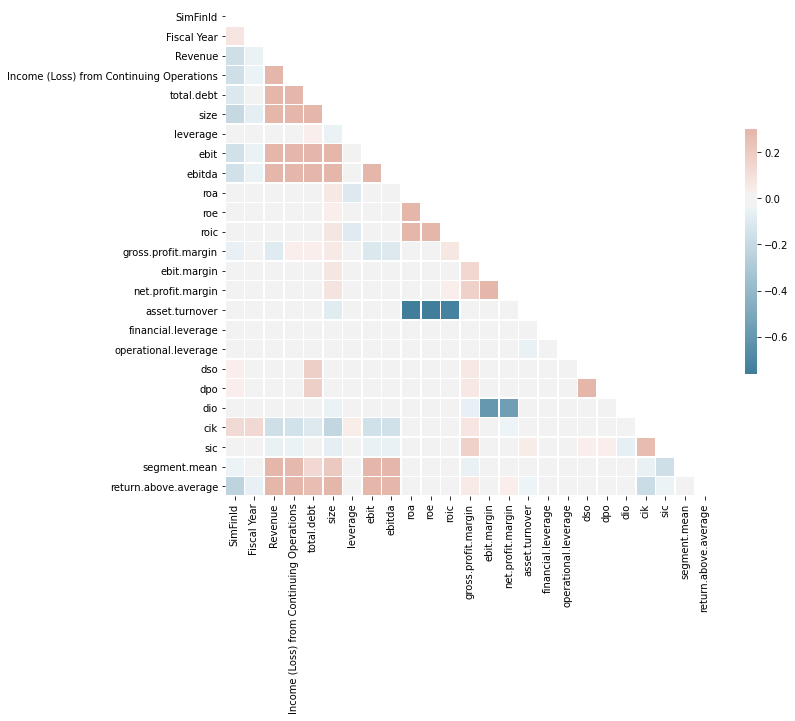

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_financial.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

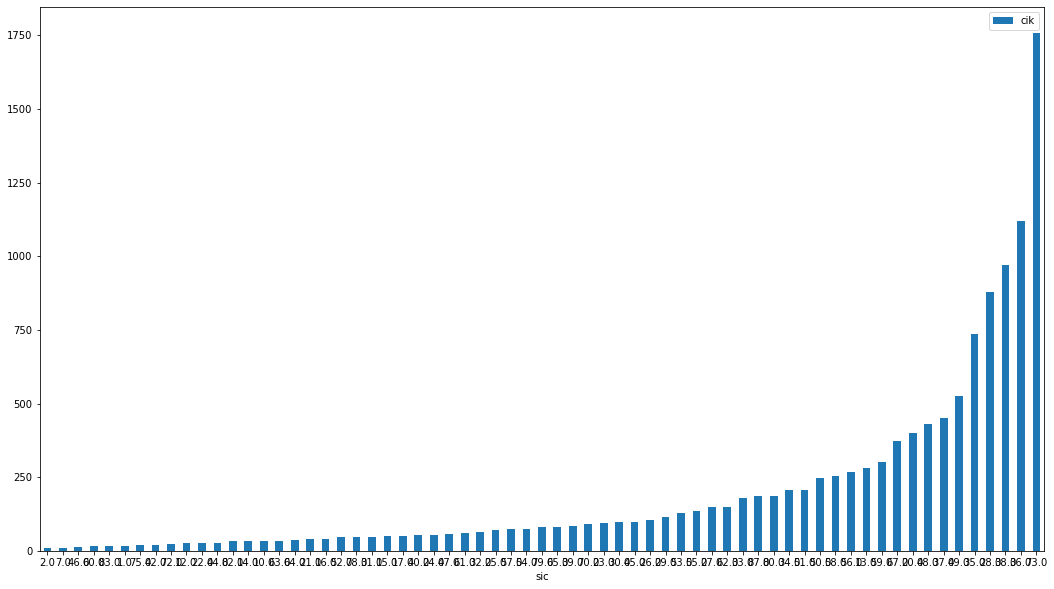

In [236]:
comp_seg = pd.DataFrame(df_financial.groupby('sic')['cik'].count()).reset_index()
comp_seg = comp_seg.sort_values('cik')
comp_seg['sic'] = comp_seg['sic'].astype('str')

import matplotlib.pyplot as plt
comp_seg.plot.bar(x='sic', y='cik', rot=0, figsize=(18,10))

#### Importing textual data

In [36]:
import os
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

In [37]:
#import txts files
with open('txts.pickle', 'rb') as handle_txts:
    txts = pickle.load(handle_txts)
txts = txts.drop('Unnamed: 0', axis=1)
with open('subs.pickle', 'rb') as handle_subs:
    subs = pickle.load(handle_subs)

In [38]:
#filter only service companies from subs file
df_txt = subs[(subs['fp']=='FY') & (subs['fy']>2011) & (subs['fy']<2020) & subs['cik'].isin(companies)]

In [39]:
df_txt_selected = subs[['adsh', 'cik', 'fy']][subs['cik'].isin(companies)]

In [40]:
#get adsh for the selected companies
selected_adsh = subs['adsh'][subs['cik'].isin(companies)]
# Check the proportion of companies - 23%
len(selected_adsh)/len(subs)

0.2300242559444769

In [41]:
#filter selected companies from txts file
txt_selected = txts[txts['adsh'].isin(selected_adsh)]
df_txt = df_txt_selected.merge(txt_selected, on='adsh')

In [42]:
len(df_txt)

884760

In [43]:
# Filtering only disclosure text blocks
df_txt = df_txt[df_txt['tag'].str.contains('Disclosure')]

In [44]:
len(df_txt)

188794

#### Merging text blocks

In [45]:
check_comp = df_financial.rename(columns={'Fiscal Year':'fy'})

In [46]:
df_txt['value'] = df_txt['value'].astype('str')

In [47]:
values = df_txt.groupby(['adsh','fy'])['value'].agg(' '.join)

In [48]:
values =  pd.DataFrame(values)

In [49]:
values.reset_index(inplace=True)

In [50]:
values = values.merge(df_txt_selected, on=['adsh', 'fy'], how='left')

In [51]:
values_n = values.drop('adsh', axis=1) 

In [52]:
df_merged = check_comp.merge(values_n, on=['cik', 'fy'], how = 'right')

In [56]:
df_merged = df_merged.replace([np.inf, -np.inf], np.nan)

In [101]:
df_merged = df_merged.dropna().reset_index(drop=True)

#### Preprocessing texts 

In [60]:
#including some non-printable character in the stopwords
from gensim.parsing.preprocessing import STOPWORDS
my_stop_words = STOPWORDS.union(set(['A&amp;B', '&amp', '\0', '\1', '\2', '\3', '\4', '\5', '\6', '\a', '\b', '\t', '\n', '\v', '\f', '\r', 
'\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a',
'\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '', 'nan', '_', '__', '___', '____', '_____', '______', '_______', '________',
'_________', '__________', '___________', '____________', '_____________', '______________', '_______________',
'________________', '_________________', '____________________']))

In [61]:
# tranform texts into a list to iterate faster 
value_list = list(df_merged['value'].astype(str))

In [62]:
from gensim.utils import tokenize
tokens = [list(tokenize(doc, lower=True, deacc=True, encoding='utf8', errors='strict')) for doc in value_list]
tokens_str = [' '.join(row) for row in tokens]

In [63]:
from gensim.parsing.preprocessing import remove_stopwords
tokens_str = [remove_stopwords(h) for h in tokens_str]

In [64]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
lemma = [lemmatizer.lemmatize(h, 'v') for h in tokens_str]

In [65]:
token_list = [word.split(' ') for word in lemma]

In [66]:
token_list = [word for word in token_list if len(word)>2]

#### word to vector

In [ ]:
#from gensim.models import Word2Vec 
#model = Word2Vec(token_list, size=300, window=5, min_count=2, sample=1e-3, sg=1, iter=5)

In [ ]:
#model.save("word2vec.model")

In [67]:
from gensim.models import Word2Vec
model = Word2Vec.load("word2vec.model")

In [68]:
word_vectors = model.wv

In [69]:
embeddings_index = {}
for w in word_vectors.wv.vocab.keys():
    embeddings_index[w] = word_vectors.wv[w]

<ipython-input-69-16010502633d>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  for w in word_vectors.wv.vocab.keys():
<ipython-input-69-16010502633d>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  embeddings_index[w] = word_vectors.wv[w]


In [70]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(token_list)
sequences = tokenizer.texts_to_sequences(token_list)

In [71]:
num_words = 50000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [72]:
length = []
for x in value_list:
    length.append(len(x.split()))
max(length)

33575

In [73]:
x_train_seq = pad_sequences(sequences, maxlen=33575)

In [74]:
x_train_seq.shape

(9765, 33575)